# GridSearch to Identify Optimal Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline

In [3]:
feature_target_file = '../output/bank_all_features_target.csv'
full_df = pd.read_csv(feature_target_file)

In [4]:
from feature_engineering import *

### Extract features from Pandas DataFrame

In [5]:
features_df, target = extract_features_target(full_df)

### Logistic Regression
`C` is the only tunable parameter. Use 5-fold cross-validation to identify optimal parameter.

In [6]:
RANDOM_STATE = 42

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features_df.values, target, random_state=RANDOM_STATE, test_size=0.2)

In [9]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [11]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best estimator: \n{}".format(grid.best_estimator_))

/home/sueliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sueliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sueliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sueliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sueliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: D

Best estimator: 
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [12]:
print(classification_report(y_test, grid.predict(X_test), target_names=["not subscribed", "subscribed"]))

                precision    recall  f1-score   support

not subscribed       0.90      0.99      0.94      7952
    subscribed       0.64      0.19      0.30      1091

   avg / total       0.87      0.89      0.86      9043



/home/sueliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Random Forest classifier
The GridSearchCV takes a very long time, **DO NOT run**

In [13]:
param_grid = {"max_features": [2, 5, 10, 20, 50],
             "n_estimators": [50, 100, 200, 500],
             "max_depth":[2, 5, 10],
             "class_weight":[{1:1, 0:1}, {1:2, 0:1}, {1:3, 0:1}, {1:10, 0:1}]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best params: \n{}".format(grid_search.best_params_))
print(classification_report(y_test, grid_search.predict(X_test)))

### Gradient Boosting Classifier

In [20]:
gbrt = GradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=5, n_estimators=200)
gbrt.fit(X_train, y_train)
print("Classification Report for GradientBoostingClassifier")
print(classification_report(y_test, gbrt.predict(X_test), target_names=["not subscribed", "subscribed"]))

Classification Report for GradientBoostingClassifier
                precision    recall  f1-score   support

not subscribed       0.91      0.98      0.94      7952
    subscribed       0.63      0.25      0.36      1091

   avg / total       0.87      0.89      0.87      9043



In [89]:
confusion_matrix(y_test, gbrt.predict(X_test))

array([[7786,  166],
       [ 814,  277]])

### Feature Importance

In [70]:
from analysis_utils import plot_feature_importances

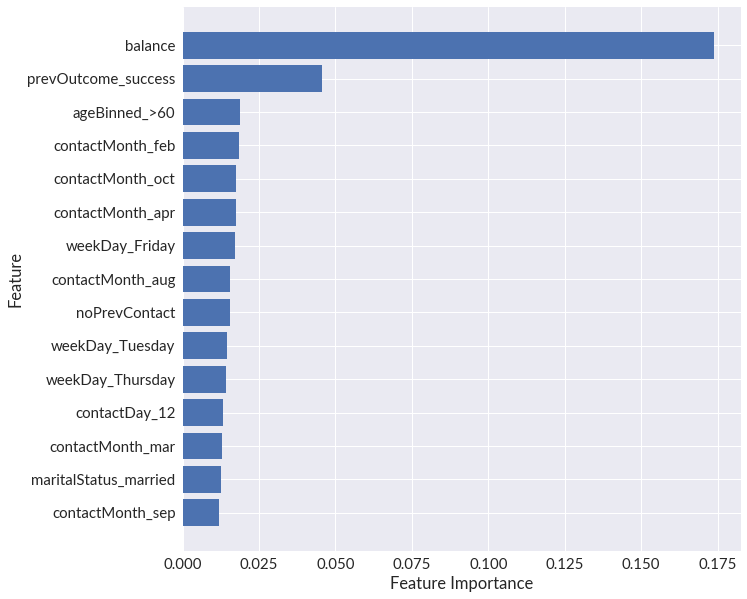

In [80]:
plt.figure(figsize=(10, 10))
plot_feature_importances(features_df, gbrt, limit=15)

### Plot ROC curves

In [21]:
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, grid.decision_function(X_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, gbrt.predict_proba(X_test)[:, 1])

/home/sueliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [27]:
import seaborn as sns
sns.set(font='Lato', font_scale=1.5)

Text(0.5,1,'ROC')

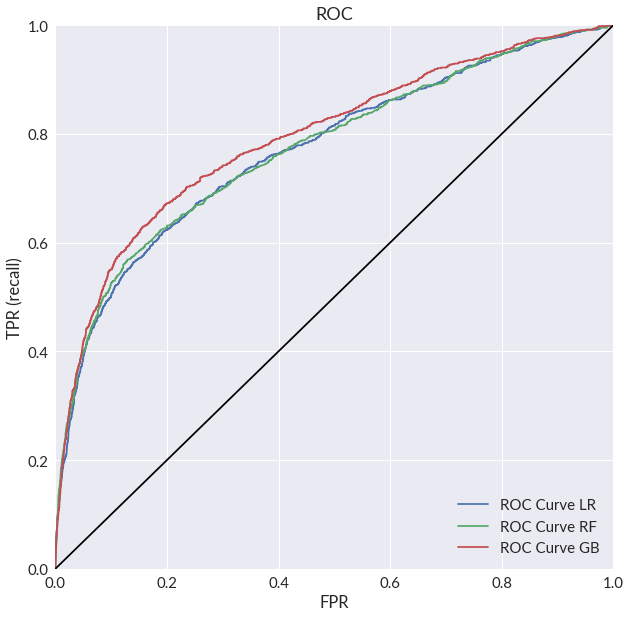

In [29]:
plt.figure(figsize=(10, 10))
plt.plot(lr_fpr, lr_tpr, label="ROC Curve LR")
plt.plot(rf_fpr, rf_tpr, label="ROC Curve RF")
plt.plot(gb_fpr, gb_tpr, label="ROC Curve GB")
plt.xlabel("FPR")
plt.plot([0, 1], [0, 1], 'k')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel("TPR (recall)")
plt.legend(loc=4)
plt.title('ROC')

### Calculate Gains Chart /Lift

In [30]:
from analysis_utils import calc_lift

In [66]:
lift_df_lr = calc_lift(X_test, y_test, grid, bins=20)
lift_df_rf = calc_lift(X_test, y_test, grid_search, bins=20)
lift_df_gb = calc_lift(X_test, y_test, gbrt, bins=20) 

/home/sueliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Text(0.5,1,'Cumulative Gains Chart')

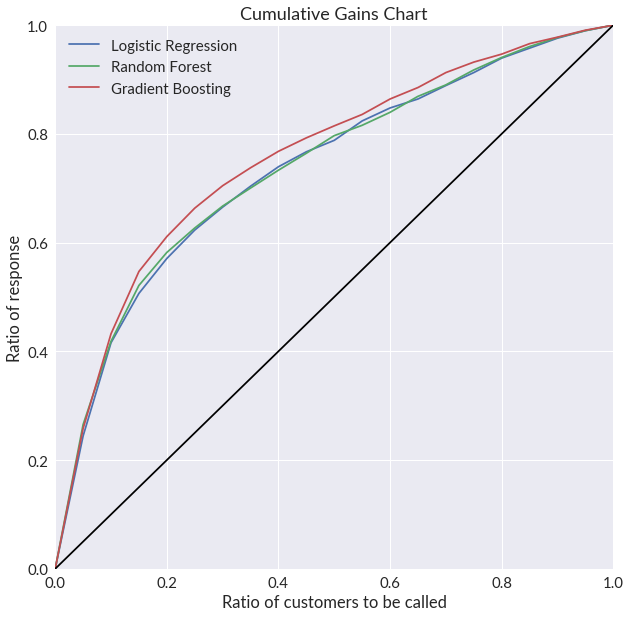

In [69]:
plt.figure(figsize=(10, 10))
total = lift_df_lr['lift_positive'].sum()
lift_positive = lift_df_lr['lift_positive'].cumsum()/total
lift_baseline = lift_df_lr['baseline_positive'].cumsum()/total
plt.plot(lift_baseline, lift_positive, label='Logistic Regression')

total = lift_df_rf['lift_positive'].sum()
lift_positive = lift_df_rf['lift_positive'].cumsum()/total
lift_baseline = lift_df_rf['baseline_positive'].cumsum()/total
plt.plot(lift_baseline, lift_positive, label='Random Forest')

total = lift_df_gb['lift_positive'].sum()
lift_positive = lift_df_gb['lift_positive'].cumsum()/total
lift_baseline = lift_df_gb['baseline_positive'].cumsum()/total
plt.plot(lift_baseline, lift_positive, label='Gradient Boosting')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Ratio of customers to be called')
plt.ylabel('Ratio of response')
plt.plot([0, 1], [0, 1], 'k')
plt.legend()
plt.title('Cumulative Gains Chart')